<h1 align="center"> Rilevazioni di transazioni fraudolente </h1>


This notebook was assembled partly copying code from:

Classificazione:

https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

Anomaly detection:

https://www.kaggle.com/code/naveengowda16/anomaly-detection-credit-card-fraud-analysis

FAVAR:

https://github.com/HoagieT/Factor-Augmented-Vector-Autoregression
https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/







<h2> Dataset: </h2>
<u1>
<li> Kaggle: <a src="https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/data" > Credit Fraud || Dealing with Imbalanced Datasets </a></li>
</ul>



<h2> Outline: </h2>

I. <b>[Installare i pacchetti](#deps)</b><br><br>

II. <b>[Comprendere i dati](#gather)</b><br><br>

III. <b>Preprocessing Generico</b><br>
a) [Rescaling](#rescaling)<br>
b) [Definizione di training e test set](#traintest)<br><br>

<h2> Classificazione </h2>

IV. <b>Preprocessing for unbalanced dataset</b><br>
a) [Gestione dello sbilanciamento](#rebalance)<br>
b) [Distribuzione del target e matrice di correlazione](#correlating)<br>
c) [Outlier Detection](#anomaly)<br>
d) [Riduzione dimensionale e visualizzazione](#clustering)<br><br>


IV. <b>Classificazione</b><br>
a) [Classificatori](#classifiers)<br>
b) [Hyperparameter tuning](#hyper)<br>
b) [Performance](#performance)<br>
c) [Confronto con reti neurali](#Neural_network)<br><br>


<h2> Anomaly detection </h2>

V. <b>Anomaly detection </b><br>
a) [Definizione dei modelli](#anomalymod)<br>
b) [Training e valutazione delle performance](#anomalyperf)<br>


<h2> Riduzione dimensionale</h2>

a) <b>FAVAR example</b><br>



<h1> I -  Installare i pacchetti </h1>
<a id="deps"></a>

In [ ]:
!pip install opendatasets
!pip install -U imbalanced-learn
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install umap-learn

# Imported Libraries
import numpy as np
import sklearn as sl
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import imblearn 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import xgboost
import lightgbm
import catboost
import umap
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import collections




# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 30.5 MB/s 
     |████████████████████████████████| 199 kB 76.1 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 

# II  - Cosa sappiamo dei dati:
<a id="gather"></a>

Il dataset che andremo a caricare contiene <b> 31 colonne </b>, la maggior parte delle quali non hanno un significato esplicito. Tutte le variabili meno 3 sono state sottoposte a PCA per questioni di privacy. Ciò implica che tutte le colonne ignote sono già state riscalate e preprocessate (per poter applicare la PCA). 
Le colonne note sono: 
<u1>
<li> <b>Time: </b> numero di secondi trascorsi tra la prima transazione del dataset quella di un certo record</li>
<li> <b>Amount: </b> ammontare della transazione</li>
<li> <b>Class: </b> 1 per transazioni fraudolente, 0 per transazioni legittime</li>
</ul>




In [ ]:
##### CARICHIAMO I DATI USANDO LE CREDENZIALI KAGGLE. Learn more: http://bit.ly/kaggle-creds 
#### user: veronicaguidetti
#### psw:  4e510d3446c996bb8f9278c9f8ff31a2
od.download('https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud')
CreditCard = pd.read_csv('./creditcardfraud/creditcard.csv')
CreditCard.describe()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: veronicaguidetti
Your Kaggle Key: ··········


100%|██████████| 66.0M/66.0M [00:00<00:00, 148MB/s]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


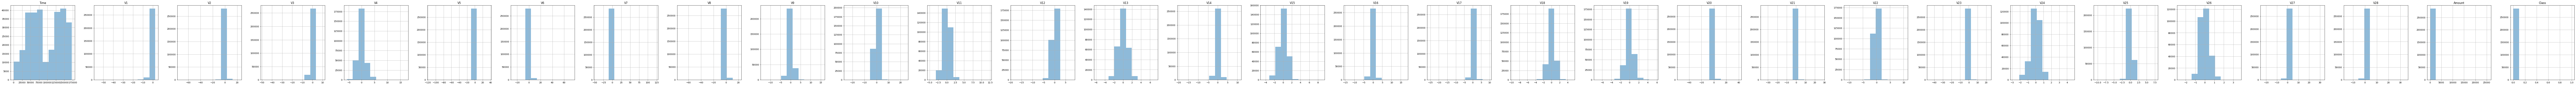

In [ ]:
fig, ax = plt.subplots(figsize=(200,6), dpi=50)
CreditCard.hist(ax=ax, layout=(1,31), alpha=0.5, label='x')
plt.show()

<h3> Riassumendo: </h3>
<ul>
<li>Tutte le variabili (comprese le $V_i$) sono parecchio sbilanciate o piccate </li>
<li>L'ammontare delle transaizioni monitorate è relativamente basso USD 88. </li>
<li>Non ci sono valori mancanti o nulli. </li>
<li> La stragrande maggioranza delle transazioni è <b>Non-fraudolenta</b> (99.83%). </li>
</ul>
<h4>Verifichiamolo...</h4>

Numero righe contenenti valori nulli: 0


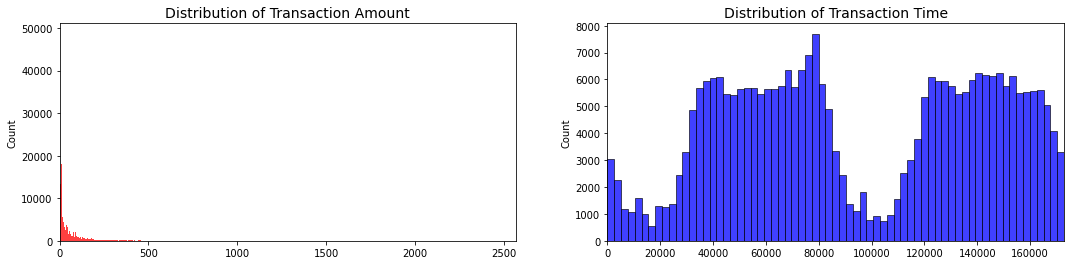

Non-fraudolente: 99.83 % del dataset
Fraudolente: 0.17 % del dataset


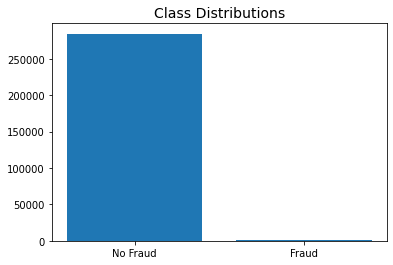

In [ ]:
#Valori nulli
print(f'Numero righe contenenti valori nulli: {CreditCard.isnull().sum().max()}')

#Distribuzione delle variabili: tempo ed ammontare
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = CreditCard['Amount'].values
time_val = CreditCard['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)/10])

sns.histplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()



# Sbilanciamento del target
print('Non-fraudolente:', round(CreditCard['Class'].value_counts()[0]/len(CreditCard) * 100,2), '% del dataset')
print('Fraudolente:', round(CreditCard['Class'].value_counts()[1]/len(CreditCard) * 100,2), '% del dataset')

plt.bar(['No Fraud', 'Fraud'], CreditCard['Class'].value_counts())
plt.title('Class Distributions', fontsize=14)
plt.show()

Il dataset è altamente sbilanciato nel target. Possiamo usare dei metodi robusti contro lo sbilanciamento (metodi ad albero e/o costi/penalizzazioni nella loss function). Oppure possiamo ribilanciare il dataset. In generale, quando il dataset è altamente sbilanciato (come nel nostro caso) non possiamo utilizzarlo così com'è, altrimenti avremmo:
<ul>
<li><b>Overfitting: </b>Il modello <b>assume</b> che non ci siano frodi e <b>non impara</b> a rilevare le caratteristiche delle transazini fraudolente. Overfitting senza feature learning. </li>
<li><b>Correlazioni sbagliate:</b> lo sbilanciamento maschera le correlazioni tra le features (ad es. "$V_i$") e il target. </li>
</ul>


# Preprocessing generico
<a id="rescaling"></a>

## Rescaling
In aggiunta allo sbilanciamento, ricordiamo che, mentre le feature $V_i$ sono state riscalate, le variabili "Time" e "Amount" non lo sono. Occupiamoci prima di questo problema.

In [ ]:
# Riscaliamo Amount e Time

from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# RobustScaler risente meno degli outiers. 
# Nello specifico sottrae la mediana e riscala considerando la distanza interquartile (IQR: Interquartile Range). 
# All'ammontare invece applichiamo una trasformazione logaritmica e poi standardizziamo
CreditCard['s_Amount'] = rob_scaler.fit_transform(CreditCard['Amount'].values.reshape(-1,1))
amount=np.log10(CreditCard['Amount']+1e-3)
CreditCard['s_Amount'] = (amount-amount.mean())/amount.std()
CreditCard['s_Time'] = rob_scaler.fit_transform(CreditCard['Time'].values.reshape(-1,1))

CreditCard.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = CreditCard['s_Amount']
scaled_time = CreditCard['s_Time']

CreditCard.drop(['s_Amount', 's_Time'], axis=1, inplace=True)
CreditCard.insert(0, 's_Amount', scaled_amount)
CreditCard.insert(1, 's_Time', scaled_time)

print(f'Amount and Time sono riscalati e sostituiti nel dataset come s_Amount e s_Time')

CreditCard.head()

Amount and Time sono riscalati e sostituiti nel dataset come s_Amount e s_Time


,s_Amount,s_Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.020918,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.964664,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.479752,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.926113,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.645495,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


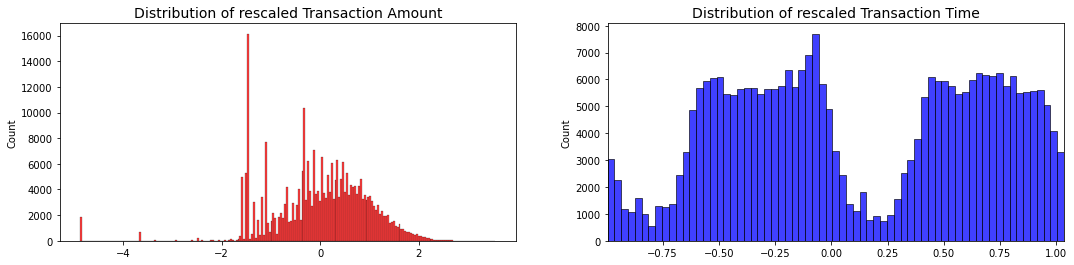

In [ ]:
#Distribuzione delle variabili: tempo ed ammontare
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = CreditCard['s_Amount'].values
time_val = CreditCard['s_Time'].values

sns.histplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of rescaled Transaction Amount', fontsize=14)
#ax[0].set_xlim([min(amount_val), max(amount_val)/10])

sns.histplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of rescaled Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# Dataset per la valutazione dei modelli 

<a id="traintest"></a>

Dobbiamo essere certi che le tecniche di under e oversampling (che andremo ad usare tra poco) e la valutazione delle performance non si mischino. 

La creazione dei test set su cui valutare le performance del modello andrebbe sempre fatta sul dataset originale, prima di applicare tecniche che modifichino la distribuzione o la densità dei dati. In generale:
<ul>
<li><b>Divisione Training/Test:</b> a partire dal dataset originale </li>
<li><b>Training dei modelli:</b> su dati dati di training ai quali possono essere applicate tecniche di riempimento, over/undersampling </li>
<li><b>Test delle performance:</b> sul test set originale </li>
</ul>


<h3>Split del dataset originale:</h3>

In linea di principio andrebbero definiti più split stratificati in train e test set. Dopodichè, su ogni training set andrebbe fatta l'analisi presente nel resto del paper e poi andrebbero valuati i risultati sul relativo test set. Per mancanza di tempo, qua fissiamo unicamente un training e un test set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Controlliamo lo sbilanciamento dei dati')
print('Original dataset ')
print('Non frodi: ', round(CreditCard['Class'].value_counts()[0]/len(CreditCard) * 100,3), '% of the dataset')
print('Frodi:     ', round(CreditCard['Class'].value_counts()[1]/len(CreditCard) * 100,3), '% of the dataset')
print('')

Xtot = CreditCard.drop('Class', axis=1)
ytot = CreditCard['Class']

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
X, original_Xtest, y, original_ytest = train_test_split(Xtot, ytot, test_size=0.2, random_state=42)


print('Training dataset ')
print('Non frodi: ', round(y.value_counts()[0]/len(y) * 100,3) ,'% of the dataset')
print('Frodi:     ', round(y.value_counts()[1]/len(y) * 100,3), '% of the dataset')
print('')

print('Test dataset ')
print('Non frodi: ', round(original_ytest.value_counts()[0]/len(original_ytest) * 100,3) ,'% of the dataset')
print('Frodi:     ', round(original_ytest.value_counts()[1]/len(original_ytest) * 100,3), '% of the dataset')
print('')



Controlliamo lo sbilanciamento dei dati
Original dataset 
Non frodi:  99.827 % of the dataset
Frodi:      0.173 % of the dataset

Training dataset 
Non frodi:  99.827 % of the dataset
Frodi:      0.173 % of the dataset

Test dataset 
Non frodi:  99.828 % of the dataset
Frodi:      0.172 % of the dataset



# Gestione dello sbilanciamento
<a id="rebalance"></a>

Andiamo ad introdurre diversi metodi per gestire i dati. Nello specifico:

* Nessuna operazione (richiederà l'utilizzo di metodi robusti)
* Random Undersampling RUS
* Undersampling informato - TOMEK,OSS,NCR (inadatto da solo)
* Oversampling informato - SMOTE,ADASYN (inadatto da solo)
* Over + undersampling informato - SMOTE + TOMEK


<img src="https://cdn-images-1.medium.com/fit/t/1600/480/1*7xf9e1EaoK5n05izIFBouA.png" >

## Random Under-Sampling:


<b>Problemi: </b> RUS tende a performare piuttosto male in casi di sbilanciamenti estremi. Infatti, il metodo causa un'enorme perdita di informazione (teniamo 492 di 284,315 transazioni legittime).

## Under-Sampling informato - TOMEK


## Under-Sampling informato - One-Sided Selection (OSS)

One-Sided Selection, or OSS for short, is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule. While CondensedNearestNeighbour is sensitive to noise and will add noisy samples, OneSidedSelection will use TomekLinks to remove noisy samples.

## Under-Sampling informato - Neighborhood Cleaning Rule (NCR)
It combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.

<b>Problemi di TOMEK - OSS - NCR: </b>  Non sono in grado di ribilanciare dataset altamente sbilanciati da soli. Vanno usati in combinazione con altre tecniche. Tomek è molto costoso. 

## Over-Sampling informato - Synthetic Minority Over-sampling Technique (SMOTE)



## Over-Sampling informato - Adaptive Synthetic (ADASYN) 



## Nota Bene:
In questo caso, per poter ottenere dei risultati in poco tempo, applichiamo un random undersampling che riduca lo sbilanciamento a 1$\div$20. 

In [ ]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
from collections import Counter
from imblearn.under_sampling import TomekLinks 
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import RandomUnderSampler


#inizializziamo i re-samplers
tl = TomekLinks(n_jobs=-1)
oss = OneSidedSelection(random_state=42)
ncr = NeighbourhoodCleaningRule()
sm = SMOTE(random_state=42)
ada = ADASYN(random_state=42)
rus = RandomUnderSampler(random_state=42)

### Riduciamo lo squilibrio a mano a 1/20 (per ridurre il tempo di esecuzione)
rus2 = RandomUnderSampler(sampling_strategy=0.05, random_state=42)

#dizionario dei dataset
sets={}

#RIDUZIONE DATASET PRE-APPLICAZIONE DI OVER/UNDERSAMPLING INFORMATO (riduzione tempo computazionale)
X_red, y_red = rus2.fit_resample(X, y)

#PROVA TOMEK - OSS - NCR DA SOLI: non ribilanciano abbastanza
print('PROVA TOMEK - OSS - NCR DA SOLI: non ribilanciano abbastanza\n')

X_resampled, y_resampled = tl.fit_resample(X_red, y_red)
print('Tomek links resampled dataset shape %s' % Counter(y_resampled))

X_resampled, y_resampled = oss.fit_resample(X_red, y_red)
print('One Sided Selection resampled dataset shape %s' % Counter(y_resampled))

X_resampled, y_resampled = ncr.fit_resample(X_red, y_red)
print('Neighbourhood Cleaning Rule %s \n' % Counter(y_resampled))

#TO KEEP
print('Elenco dei metodi che teniamo in considerazione')

sets['original']=[X, y]
print('0 Original %s' % Counter(y))

#RUS
X_resampled, y_resampled = rus.fit_resample(X, y)
sets['RUS']=[X_resampled, y_resampled]
print('1 RUS %s' % Counter(y_resampled))

X_resampled, y_resampled = sm.fit_resample(X_red, y_red)
sets['SMOTE']=[X_resampled, y_resampled]
print('2 ONLY SMOTE %s' % Counter(y_resampled))

X_resampled, y_resampled = ada.fit_resample(X_red, y_red)
sets['ADASYN']=[X_resampled, y_resampled]
print('3 ONLY ADASYN %s' % Counter(y_resampled))

X_resampled, y_resampled = sm.fit_resample(X_red, y_red)
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled)
sets['SMOTE+Tomek']=[X_resampled, y_resampled]
print('4 SMOTE + Tomek %s' % Counter(y_resampled))

X_resampled, y_resampled = sm.fit_resample(X_red, y_red)
X_resampled, y_resampled = oss.fit_resample(X_resampled, y_resampled)
sets['SMOTE+OSS']=[X_resampled, y_resampled]
print('5 SMOTE + OSS %s' % Counter(y_resampled))

X_resampled, y_resampled = sm.fit_resample(X_red, y_red)
X_resampled, y_resampled = ncr.fit_resample(X_resampled, y_resampled)
sets['SMOTE+NCR']=[X_resampled, y_resampled]
print('6 SMOTE + NCR %s' % Counter(y_resampled))

X_resampled, y_resampled = ada.fit_resample(X_red, y_red)
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled)
sets['ADASYN+Tomek']=[X_resampled, y_resampled]
print('7 ADASYN + Tomek %s' % Counter(y_resampled))

X_resampled, y_resampled = ada.fit_resample(X_red, y_red)
X_resampled, y_resampled = oss.fit_resample(X_resampled, y_resampled)
sets['ADASYN+OSS']=[X_resampled, y_resampled]
print('8 ADASYN + OSS %s' % Counter(y_resampled))

X_resampled, y_resampled = ada.fit_resample(X_red, y_red)
X_resampled, y_resampled = ncr.fit_resample(X_resampled, y_resampled)
sets['ADASYN+NCR']=[X_resampled, y_resampled]
print('9 ADASYN + NCR %s' % Counter(y_resampled))

PROVA TOMEK - OSS - NCR DA SOLI: non ribilanciano abbastanza

Tomek links resampled dataset shape Counter({0: 7864, 1: 394})
One Sided Selection resampled dataset shape Counter({0: 6657, 1: 394})
Neighbourhood Cleaning Rule Counter({0: 7710, 1: 394}) 

Elenco dei metodi che teniamo in considerazione
0 Original Counter({0: 227451, 1: 394})
1 RUS Counter({0: 394, 1: 394})
2 ONLY SMOTE Counter({0: 7880, 1: 7880})
3 ONLY ADASYN Counter({1: 7900, 0: 7880})
4 SMOTE + Tomek Counter({0: 7880, 1: 7879})
5 SMOTE + OSS Counter({0: 7880, 1: 2492})
6 SMOTE + NCR Counter({0: 7880, 1: 7877})
7 ADASYN + Tomek Counter({1: 7900, 0: 7880})
8 ADASYN + OSS Counter({0: 7880, 1: 7807})
9 ADASYN + NCR Counter({0: 7880, 1: 7653})


## Scegliere il metodo di costruzione del dataset tra:
* 'RUS'
* 'SMOTE'
* 'ADASYN'
* 'SMOTE+Tomek'
* 'SMOTE+OSS'
* 'SMOTE+NCR'
* 'ADASYN+Tomek'
* 'ADASYN+OSS'
* 'ADASYN+NCR'

In [ ]:
# Scegliere il metodo
method='SMOTE+OSS'
X_resampled, y_resampled = sets[method]
# Shuffle dataframe rows
new_df = pd.concat([X_resampled,y_resampled],axis=1)
print(f'{method}: {Counter(y_resampled)}')

SMOTE+OSS: Counter({0: 7880, 1: 2492})


#  Distribuzione del target e matrice di correlazione: 
<a id="correlating"></a>
Ora che abbiamo il nostro training set, andiamo a vedere quanto sono cambiate le relazioni tra i dati e quanto si riescono a separare le due classi.  

Distribution of the Classes in the subsample dataset
0    0.759738
1    0.240262
Name: Class, dtype: float64


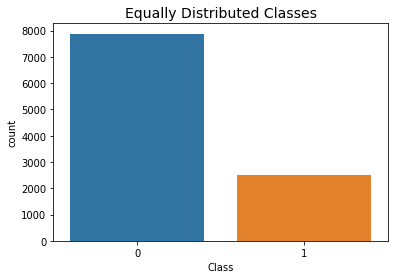

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> Matrici di correlazione </h3>

Dobbiamo capire quali sono le relazioni tra i dati per poter impostare i nostri modelli predittivi. Nello spcifico siamo interessati a capire se qualche feature correla con il target. 


Nello specifico guardiamo le correlazioni sia sul dataset originale, sia su quello bilanciato. Questo ci fa avere un'idea di quanto siano cambiate le relazioni tra le variabili. 

**Da notare** quanto le variabili $V_i$ siano ortogonali nel dataset originale (PCA) e non lo siano più nel dataset finale. Non ce ne dobbiamo preoccupare al momento perchè siamo solo interessati a trovare la correlazione tra le features e il target. E' comunque bene notare come la tecnica di undersamplig cambi le relazioni tra i dati. 

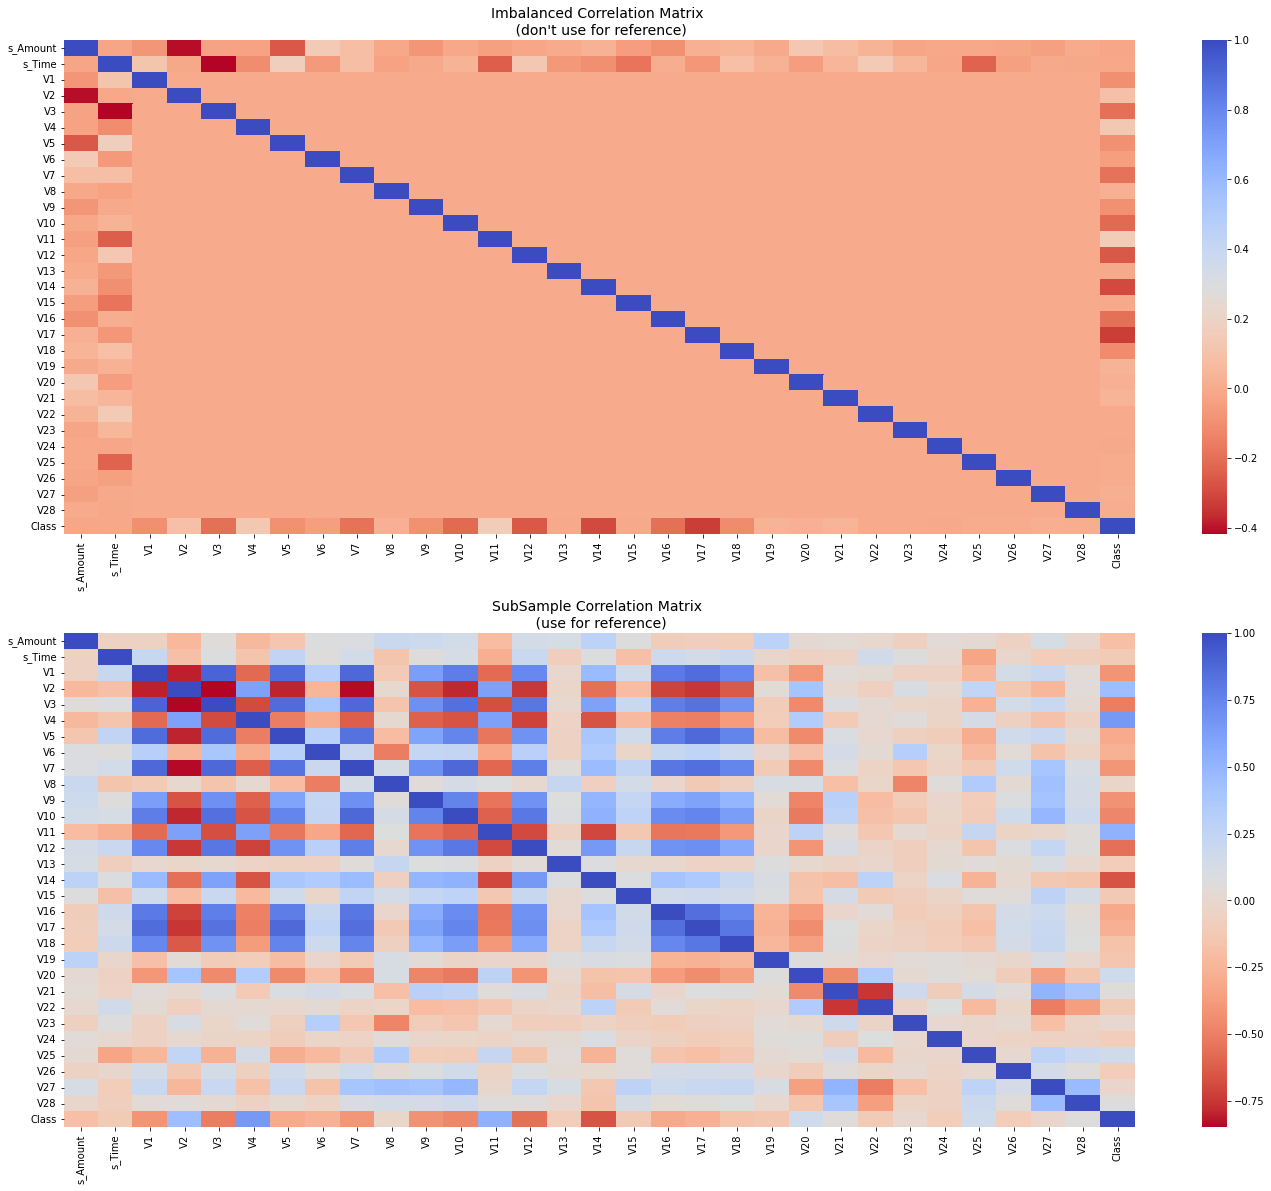

In [ ]:
# Confrontiamo le matrici di correlazione
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# sui dati totali
corr = CreditCard.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# e sui dati subsampled
balanced_corr = new_df.corr()
sns.heatmap(balanced_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

## Correlazioni alte tra feature e classe


### Boxplot
Utilizziamo i boxplots per vedere più chiaramente la relazione tra le features $V_i$ e la classe a cui appartengono le transazioni. Stampiamo i boxplot delle features che correlano con il target per più di una certa soglia (qua fissata all'80% della correlazione maggiore per poter sempre eseguire la cella... un valore ragionevole potrebbe essere 0.6).

<ul>
<li> <b> Determinare la correlazione cutoff: </b> decidiamo quale valore di correlazione tra variabili e classe viene considerato "alto". QUesto determina le variabili su cui andiamo a cercare gli outliers.</li>
<li> <b> Boxplot: </b> Utilizziamo i boxplots per vedere più chiaramente la relazione tra le features $V_i$ e la classe a cui appartengono le transazioni. </li>
</ul>

**Nota Bene**: qua fissiamo il cutoff della correlazione all'80% della correlazione maggiore. Questo viene fatto solo ed unicamente per poter sempre eseguire la cella senza errori. In generale, un valore ragionevole per il cutoff potrebbe essere 0.6.

Cutoff: 0.527824390137813


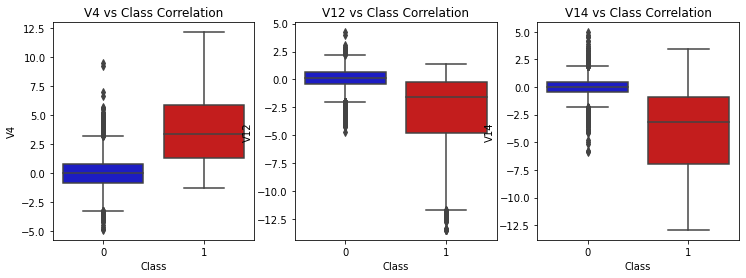

In [ ]:
## Fissare la soglia (in questo caso all'80% della correlazione massima per far funzionre il codice)
cutoff_corr=np.sort(np.abs(balanced_corr['Class']).to_numpy())[-2]*0.8
print(f'Cutoff: {cutoff_corr}')
v_HC=list(balanced_corr[np.abs(balanced_corr['Class'])>cutoff_corr].index)
v_HC.remove('Class')

nv=len(v_HC)

f, axes = plt.subplots(ncols=nv, figsize=(nv*4.1,4))
colors = ["#0101DF", "#DF0101"]
for i in range(nv):
  sns.boxplot(x="Class", y=v_HC[i], data=new_df, palette=colors, ax=axes[i])
  axes[i].set_title(f'{v_HC[i]} vs Class Correlation')
plt.show()

# Outlier detection
<a id="anomaly"></a>

Il nostro obiettivo principale in questa sezione è rimuovere gli "outliers estremi" dalle variabili che hanno un'elevata correlazione con la classe. Ciò avrà un impatto positivo sulla precisione dei nostri modelli.<br><br>

<img src="https://mathlake.com/uploads/images/f6c2613cb98b77b9baa6ce96ecc31714.png">






### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> Lo calcoliamo in base alla differenza tra il 75° percentile e il 25° percentile.   </li>
<li> <b>Boxplots: </b> Oltre a mostrare il 25% ed il 75% evidenzia gli outliers. </li>
</ul>

### Outlier Removal Tradeoff:
Dobbiamo stare attenti a quanto vogliamo che la soglia rimuova i valori anomali. Determiniamo la soglia moltiplicando un numero (es: 1,5) per (Interquartile Range). Più alta è questa soglia, meno valori anomali rileverà (moltiplicando per un numero più alto, ad esempio: 3) e più bassa sarà questa soglia, più valori anomali rileverà. 

In questa sezione vogliamo concentrarci maggiormente sugli "outlier estremi" piuttosto che sui valori anomali in generale. Come mai? perché richieremmo di perdere informazioni e compromettere la precisione dei modelli. Prova a modificare con questa soglia per vedere come influisce sull'accuratezza dei nostri modelli di classificazione.  <br><br>



### Nelle prossime celle:
<ul>
<li> <b> Visualizziamo le distribuzioni: </b> visualizzare la distribuzione delle variabili che utilizzeremo per eliminare alcuni dei valori anomali.</li>
<li><b>Determinare le soglie per gli outliers: </b> Decidiamo quale valore, a,moltiplicherà IQR nella determinazione degli outliers estremi. Procediamo con la determinazione della soglia superiore (q75 + a*IQR) ed inferiore (q25 - a*IQR). </li>
<li> <b>Rimozione dei valori: </b> rimuovere i valori che giaccino al di fuori del range ammesso. </li>
<li> <b> Confronto Boxplot: </b> Visualizza attraverso il boxplot che il numero di "outliers estremi" è stato ridotto. </li>
</ul>


**Reference**: Interquartile Range Method: <a src="https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/"> How to Use Statistics to Identify Outliers in Data </a> 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

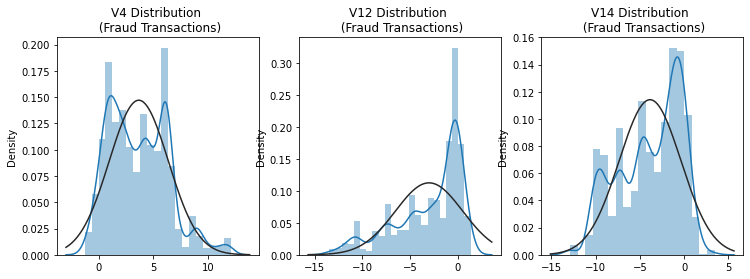

V4 Lower and upper bounds: -5.428914229547731, 12.563235659324057
Number V4 outliers: 0
Number of Instances after outliers removal: 10372
V12 Lower and upper bounds: -11.678030028777576, 6.576884678974635
Number V12 outliers: 51
Number of Instances after outliers removal: 10321
V14 Lower and upper bounds: -16.04616609114946, 8.197166693468107
Number V14 outliers: 0
Number of Instances after outliers removal: 10321


In [ ]:
from scipy.stats import norm
threshold=1.5

v_fraud_dist={}
q25={}
q75={}
IQR={}
f, axes = plt.subplots(ncols=nv, figsize=(nv*4.1,4))
for i in range(nv):
  v_fraud_dist[v_HC[i]] = new_df[v_HC[i]].loc[new_df['Class'] == 1].values
  q25[v_HC[i]], q75[v_HC[i]] = np.percentile(v_fraud_dist[v_HC[i]], 25), np.percentile(v_fraud_dist[v_HC[i]], 75)
  IQR[v_HC[i]]=q75[v_HC[i]]-q25[v_HC[i]]
  sns.distplot(v_fraud_dist[v_HC[i]],ax=axes[i], fit=norm)
  axes[i].set_title(f'{v_HC[i]} Distribution \n (Fraud Transactions)')
plt.show()


outliers={}

for i in range(nv):
  v_low, v_up = q25[v_HC[i]] - threshold*IQR[v_HC[i]], q75[v_HC[i]] + threshold*IQR[v_HC[i]]
  print(f'{v_HC[i]} Lower and upper bounds: {v_low}, {v_up}')
  outliers[v_HC[i]] = [x for x in v_fraud_dist[v_HC[i]] if x < v_low or x > v_up]
  print(f'Number {v_HC[i]} outliers: {len(outliers[v_HC[i]])}')
  new_df = new_df.drop(new_df[(new_df[v_HC[i]] > v_up) | (new_df[v_HC[i]] < v_low)].index)
  print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Fewer Outliers!


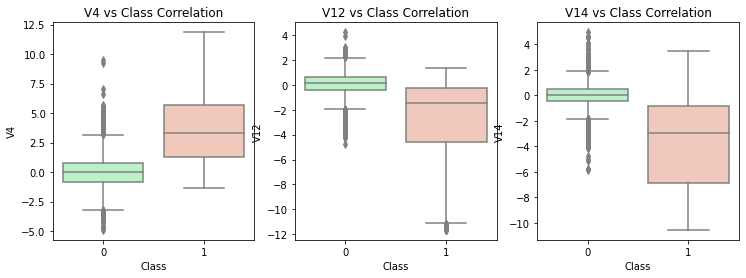

In [ ]:
print('Fewer Outliers!')

f, axes = plt.subplots(ncols=nv, figsize=(nv*4.1,4))
new_colors = ['#B3F9C5', '#f9c5b3']
for i in range(nv):
  sns.boxplot(x="Class", y=v_HC[i], data=new_df, palette=new_colors, ax=axes[i])
  axes[i].set_title(f'{v_HC[i]} vs Class Correlation')
plt.show()

#xy=(0.95, -16.5)

<h2>Riduzione dimensionale e visualizzazione </h2>
<a id="clustering"></a>

<h3> Usiamo tre tecniche:  </h3>
<ul>
<li> <b>PCA </b></li>
<li> <b>t-SNE</b> </li>
<li> <b>UMAP</b> </li>
</ul> 

<h3> In generale: </h3>

L'algoritmo t-SNE è lento ma può raggruppare in modo abbastanza accurato i casi che erano frode e non frode nel nostro set di dati.
Questo ci dà un'indicazione che i modelli predittivi funzioneranno abbastanza bene nel separare i casi di frode da quelli non fraudolenti. (Le performance variano al variare della tecnica di ribilanciamento utilizzata)

In [ ]:
# New_df is from the random undersample data (fewer instances)
X_train = new_df.drop('Class', axis=1)
y_train = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, perplexity=50.0).fit_transform(X_train.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# UMAP
t0 = time.time()
X_reduced_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_train.values)
t1 = time.time()
print("UMAP took {:.2} s".format(t1 - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


T-SNE took 7.7e+01 s
PCA took 0.048 s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


UMAP took 2.5e+01 s


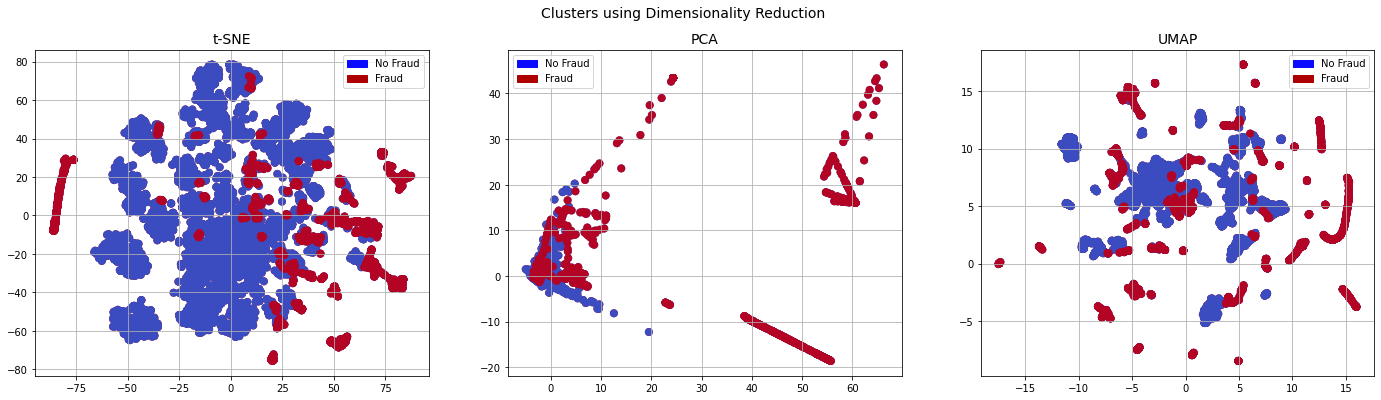

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax3.scatter(X_reduced_umap[:,0], X_reduced_umap[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_umap[:,0], X_reduced_umap[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('UMAP', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2> Classificatori:  </h2>
<a id="classifiers"></a>

In questa sezione creiamo 8 tipi di classificatori e decidiamo quale classificatore è più efficace nel rilevare le <b>transazioni fraudolente</b>
<ul>
<li>I modelli sono:
<ul>
<li> <b> Logistic Regression </b> 
<li><b> KNN classifier </b> </li>
<li><b> Support Vector Classifier </b> </li>
<li><b> Decision Tree Classifier </b>  </li>
<li><b> Gradient Boosting Classifier </b>  </li>
<li><b> XGBoost </b> </li>
<li><b> LightGBC </b></li>
</ul></li>
<li> Inizializziamo i modelli con gli iperparametri di default </li>
<li> Effettuamo una cross-validation sul <b> training set </b> per capire quali siano le performance medie di questi modelli sul training set. Il metodo riesce ad imparare le caratteristiche del training set. <b> NB: </b> questi valori andranno comparati con le performance reali (sul test set). I modelli tendono a fare overfitting. </li>
<li>Ottimizzare i modelli tramite una <b>Grid search cross-validation</b></li>
<li>Salvare i classificatori ottimizzati</li>
</ul>



In [ ]:
# Let's implement simple classifiers 
baseline_classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier()}

In [ ]:
#Applying cross validation training.
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

for key, model in baseline_classifiers.items():
    t0 = time.time()
    print(f'\nTraining {key}')
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    training_score = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, error_score='raise', verbose=0)
    t1 = time.time()
    print("Classifiers: ", model.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")
    print(f"{key} took {round(t1 - t0,2)} s")



Training LogisiticRegression
Classifiers:  LogisticRegression Has a training score of 92.0 % accuracy score
LogisiticRegression took 1.74 s

Training KNearest
Classifiers:  KNeighborsClassifier Has a training score of 98.0 % accuracy score
KNearest took 3.08 s

Training Support Vector Classifier
Classifiers:  SVC Has a training score of 94.0 % accuracy score
Support Vector Classifier took 11.74 s

Training DecisionTreeClassifier
Classifiers:  DecisionTreeClassifier Has a training score of 97.0 % accuracy score
DecisionTreeClassifier took 2.8 s

Training GradientBoostingClassifier
Classifiers:  GradientBoostingClassifier Has a training score of 97.0 % accuracy score
GradientBoostingClassifier took 74.0 s

Training XGBClassifier
Classifiers:  XGBClassifier Has a training score of 97.0 % accuracy score
XGBClassifier took 14.64 s

Training LGBMClassifier
Classifiers:  LGBMClassifier Has a training score of 100.0 % accuracy score
LGBMClassifier took 8.03 s


<h2> Hyperparameter tuning </h2>
<a id="hyper"></a>

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# parameters grid 
log_reg_params = {'max_iter': [1000],
                  "penalty": ['l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                  }

knears_params = {"n_neighbors": list(range(2,5,1)), 
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
                 }

svc_params = {'C': [0.5, 0.7, 0.9, 1], 
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
              }

tree_params = {
    "criterion": ["gini", "entropy"], 
    "max_depth": list(range(2,4,1)), 
    "min_samples_leaf": list(range(5,7,1))
    }

gradient_params = {
    'max_depth': [2,3,5],
    'n_estimators': [10,30,100],
    'learning_rate': [0.1, 0.01, 0.05]
}


#initialize grid searches
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, n_jobs=-1, verbose=0)     # Logistic regression
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, n_jobs=-1, verbose=0)     # KNears 
grid_svc = GridSearchCV(SVC(), svc_params, n_jobs=-1, verbose=0)                            # Support Vector Classifier
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, n_jobs=-1, verbose=0)       # DecisionTree Classifier
grid_gbc=GridSearchCV(GradientBoostingClassifier(), gradient_params, n_jobs=-1, verbose=0)  # GradientBoostingClassifier
grid_xgbc=GridSearchCV(XGBClassifier(), gradient_params, n_jobs=-1, verbose=0)              # XGBClassifier
grid_lgbmc=GridSearchCV(LGBMClassifier(), gradient_params, n_jobs=-1, verbose=0)            # LGBMClassifier


#fit
print('\n LOGISTIC \n')
grid_log_reg.fit(X_train, y_train)
print('\n KNN \n')
grid_knears.fit(X_train, y_train)
print('\n SVC \n')
grid_svc.fit(X_train, y_train)
print('\n R-TREE \n')
grid_tree.fit(X_train, y_train)
print('\n GBC \n')
grid_gbc.fit(X_train, y_train)
print('\n XGBC \n')
grid_xgbc.fit(X_train, y_train)
print('\n LGBMC \n')
grid_lgbmc.fit(X_train, y_train)



#Best parameters.
log_reg = grid_log_reg.best_estimator_
knears_neighbors = grid_knears.best_estimator_
svc = grid_svc.best_estimator_
tree_clf = grid_tree.best_estimator_
gbc=grid_gbc.best_estimator_
xgbc=grid_xgbc.best_estimator_
lgbmc=grid_lgbmc.best_estimator_


optimized_classifiers = {
    "LogisiticRegression": log_reg,
    "KNearest": knears_neighbors,
    "Support Vector Classifier": svc,
    "DecisionTreeClassifier": tree_clf,
    "GradientBoostingClassifier": gbc,
    "XGBClassifier": xgbc,
    "LGBMClassifier": lgbmc}


 LOGISTIC 


 KNN 



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 SVC 


 R-TREE 


 GBC 


 XGBC 


 LGBMC 



## Neural Networks comparison (solo con OverSampling, troppi pochi dati): 
<a id="neural_networks"></a>
In questa sezione implementeremo una semplice rete neurale (Multi Layer Perceptron) con 2 hidden layers per vedere se funziona meglio degli altri modelli più "classici".<br><br>

<img src="https://jacobsenecal.com/static/img/NeuralNetwork.png" width=500> <br>


### NB:
Visto che andiamo a lavorare con pochi dati, è il caso di implementare una tecnica di early stopping per prevenire overfitting. Questa fa si che il training si arresti quando le performance sul traiing e sul validation set (ottenuto dal training set tramite sampling stratificato) sono comparabili. 
L'ottimizzatore utilizzato è ADAM, una versione di Stochastic Gradient Descent che adatta il learning rate utilizzando stime del primo e del secondo momento dei gradienti della loss function rispetto ai parametri.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.metrics import categorical_crossentropy


n_inputs = X_train.shape[1]

MLP = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
MLP.summary()

opt=keras.optimizers.Adam(lr=1e-3)
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    restore_best_weights=True,
    verbose=1
)

MLP.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
MLP.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=50, shuffle=True, verbose=2,callbacks=[cb])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 32)                992       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,044
Trainable params: 3,044
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
258/258 - 1s - loss: 0.1660 - accuracy: 0.9583 - val_loss: 1.0709 - val_accuracy: 0.5952 - 966ms/epoch - 4ms/step
Epoch 2/50
258/258 - 0s - loss: 0.0670 - accuracy: 0.9799 - val_loss: 0.7880 - val_accuracy: 0.6557 - 322ms/epoch - 1ms/step
Epoch 3/50
258/258 - 0s - loss: 0.0529 - accuracy: 0.9821 - val_loss: 0.7230 - val_accuracy: 0.6910 - 336ms/epoch - 1ms/step
Epoch 4/50
258/258 - 0s - loss: 0.0422 - accuracy: 0.9856 - val_loss: 0.4308 - val_accuracy: 0.7985 - 327ms/epoch - 1ms/step
Epoch 5/50
258/258 - 0s - loss: 0.0344 - accuracy: 0.9879 - val_loss: 0.4175 - val_accuracy: 0.8063 - 333ms/epoch - 1ms/step
Epoch 6/50
258/258 - 0s - loss: 0.0278 - accuracy: 0.9904 - val_loss: 0.3824 - val_accuracy: 0.8281 - 332ms/epoch - 1ms/step
Epoch 7/50
258/258 - 0s - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.2795 - val_accuracy: 0.8877 - 319ms/epoch - 1ms/step
Epoch 8/50
258/258 - 0s - loss: 0.0218 - accuracy: 0.9931 - val_loss: 0.2930 - val_accuracy: 0.8794 - 313ms/epoch - 1ms/step


# Performance
<a id="performance"></a>
Valutiamo le performance dei vari modelli sul <b>test set</b> definito inizialmente. Essendo il dataset sbilanciato, l'accuracy non è sufficiente.


### Terminologia e metriche:
<ul>
<li><b>True Positives (TP):</b> Transazioni fraudolente correttamente classificate </li>
<li><b>False Positives (FP):</b> Transazioni fraudolente classificate erroneamente</li>
<li> <b>True Negative (TN):</b> Transazioni legittime correttamente classificate </li>
<li> <b>False Negative (FN):</b> Transazioni legittime classificate erroneamente</li>
<li><b>Precision: </b>  $\frac{TP}{(TP + FP)}$  </li>
<li><b> Recall: </b> $\frac{TP}{(TP + FN)}$   </li>
<li><b> F1-score: </b> $\frac{2 Precision * Recall}{(Precision + Recall)}$  media geometrica di precision e recall </li>
</ul>

La <b>Precision</b>, come suggerisce il nome, dice quanto sia preciso (sicuro) il nostro modello nel rilevare le transazioni fraudolente. La <b>Recall</b> invece è la quantità di casi di frode reale che il nostro modello è in grado di rilevare.

<b>Precision/Recall Tradeoff:</b> Un modello con un'elevata precision è un modello che rileva pochi casi di frode in generale (in presenza di falsi positivi il denominatore aumenta). Un'alta recall invece ci dice invece the il modello è in grado di riconoscere correttamente un'elevata percentuale di frodi (tralasciando quale sia la percentuale dei falsi positivi). Chiaramente questi due obiettivi sono in contrasto nei casi estremi:
<ul>
<li> se l'algoritmo prevede un solo caso di frode (una frode reale), la precision sarà 1 mentre la recall sarà 1/(# frodi nel dataset) </li>
<li> se l'algoritmo prevede solo frodi, la recall sarà 1 mentre la precision sarà pari alla frazione di frodi nel dataset</li>
</ul>

No weighting
Logistic Regression: 
Accuracy: 97.48
Precision: 5.98
Recall: 92.86
F1: 11.23
ROC-AUC score: 0.9790775412584842


KNN classification: 
Accuracy: 99.14
Precision: 15.4
Recall: 88.78
F1: 26.24
ROC-AUC score: 0.9396745403282304


SV classification: 
Accuracy: 98.7
Precision: 9.02
Recall: 72.45
F1: 16.05
ROC-AUC score: 0.8559491748303149


Tree classification: 
Accuracy: 95.83
Precision: 3.44
Recall: 85.71
F1: 6.61
ROC-AUC score: 0.9591002305536733


GradientBoost classification: 
Accuracy: 99.39
Precision: 20.24
Recall: 86.73
F1: 32.82
ROC-AUC score: 0.9910555475003733


XGBoost classification: 
Accuracy: 99.43
Precision: 21.84
Recall: 89.8
F1: 35.13
ROC-AUC score: 0.9910500743628909


LGBMC classification: 
Accuracy: 99.41
Precision: 21.31
Recall: 89.8
F1: 34.44
ROC-AUC score: 0.9902359227315012


MLP classification: 
Accuracy: 99.41
Precision: 21.07
Recall: 88.78
F1: 34.05
ROC-AUC score: 0.9410110625567053




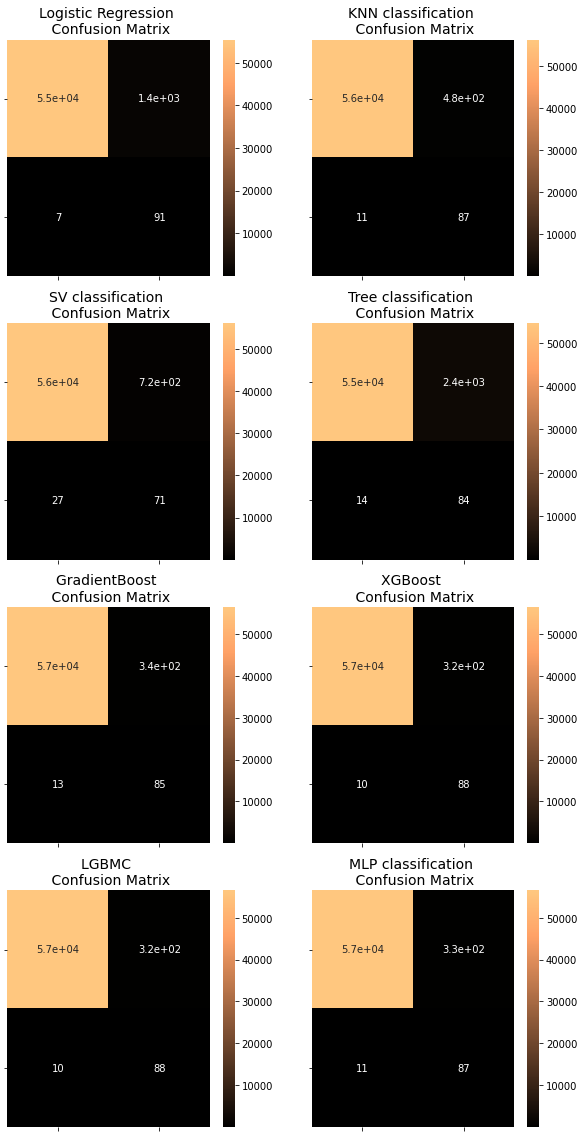

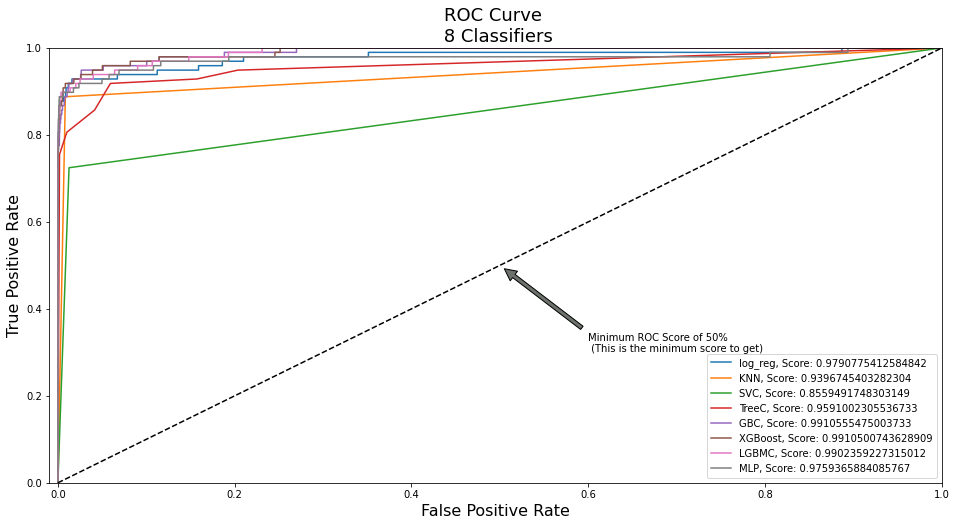

In [ ]:
from sklearn.metrics import precision_recall_fscore_support,roc_curve,roc_auc_score,confusion_matrix
performance={} #going to contain [accuracy, precision, recall, f1]
CMs={} #going to contain confusion matrices
ROCs={}


########
## introduce cost? depends on data balancing.
#### Introduce sample weight to satisfy:
#### n1*c1=n0*c0
#### n1*c1+n0*c0=n1+n0
########

weighting='no'

if weighting=='no':
  weights=np.ones_like(y_train)
  print('No weighting')
if weighting=='yes':
  n0=(y_train==0).astype(int).sum()
  n1=(y_train==1).astype(int).sum()
  c0=(n1+n0)/(2*n0)
  c1=(n1+n0)/(2*n1)
  weights=(y_train==0)*c0+(y_train==1)*c1


# Fittiamo i modelli sull'intero training dataset

fig, ax = plt.subplots(4, 2,figsize=(10,20))

##logistic regression
log_reg.fit(X_train, y_train,sample_weight=weights)
pred = log_reg.predict_proba(original_Xtest)
y_pred = [round(value) for value in pred[:,1]]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
ROCs['log_reg']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['log_reg'].append(roc_auc_score(original_ytest,pred[:,1]))
performance['log_reg']=[accuracy,prec,rec,f1]
print('Logistic Regression: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['log_reg'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['log_reg']=cf
sns.heatmap(cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')



# Knn classifier
knears_neighbors.fit(X_train, y_train)
pred = knears_neighbors.predict(original_Xtest)
y_pred = [round(value) for value in pred]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['KNN']=[accuracy,prec,rec,f1]
ROCs['KNN']=list(roc_curve(original_ytest, pred))
ROCs['KNN'].append(roc_auc_score(original_ytest,pred))
print('KNN classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['KNN'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['KNN']=cf
sns.heatmap(cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0, 1].set_title("KNN classification \n Confusion Matrix", fontsize=14)
ax[0, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')


# SVClassifier
svc.fit(X_train, y_train,sample_weight=weights)
pred = svc.predict(original_Xtest)
y_pred = [round(value) for value in pred]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['SVC']=[accuracy,prec,rec,f1]
ROCs['SVC']=list(roc_curve(original_ytest, pred))
ROCs['SVC'].append(roc_auc_score(original_ytest,pred))
print('SV classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['SVC'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['SVC']=cf
sns.heatmap(cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1, 0].set_title("SV classification \n Confusion Matrix", fontsize=14)
ax[1, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')


# Random Tree
tree_clf.fit(X_train, y_train,sample_weight=weights)
pred = tree_clf.predict_proba(original_Xtest)
y_pred = [round(value) for value in pred[:,1]]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['TreeC']=[accuracy,prec,rec,f1]
ROCs['TreeC']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['TreeC'].append(roc_auc_score(original_ytest,pred[:,1]))
print('Tree classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['TreeC'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['TreeC']=cf
sns.heatmap(cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1, 1].set_title("Tree classification \n Confusion Matrix", fontsize=14)
ax[1, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')


# Gradient boosting classifier
gbc.fit(X_train, y_train,sample_weight=weights)
pred = gbc.predict_proba(original_Xtest)
y_pred = [round(value) for value in pred[:,1]]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['GBC']=[accuracy,prec,rec,f1]
ROCs['GBC']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['GBC'].append(roc_auc_score(original_ytest,pred[:,1]))
print('GradientBoost classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['GBC'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['GBC']=cf
sns.heatmap(cf, ax=ax[2][0], annot=True, cmap=plt.cm.copper)
ax[2, 0].set_title("GradientBoost \n Confusion Matrix", fontsize=14)
ax[2, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')


# XGBoost 
xgbc.fit(X_train, y_train,sample_weight=weights)
pred = xgbc.predict_proba(original_Xtest)
y_pred = [round(value) for value in pred[:,1]]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['XGBoost']=[accuracy,prec,rec,f1]
ROCs['XGBoost']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['XGBoost'].append(roc_auc_score(original_ytest,pred[:,1]))
print('XGBoost classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['XGBoost'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['XGBoost']=cf
sns.heatmap(cf, ax=ax[2][1], annot=True, cmap=plt.cm.copper)
ax[2, 1].set_title("XGBoost \n Confusion Matrix", fontsize=14)
ax[2, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')

# LightGBMC
lgbmc.fit(X_train, y_train,sample_weight=weights)
pred = lgbmc.predict_proba(original_Xtest)
y_pred = [round(value) for value in pred[:,1]]
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['LGBMC']=[accuracy,prec,rec,f1]
ROCs['LGBMC']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['LGBMC'].append(roc_auc_score(original_ytest,pred[:,1]))
print('LGBMC classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {ROCs['LGBMC'][3]}")
cf = confusion_matrix(original_ytest, y_pred)
CMs['LGBMC']=cf
sns.heatmap(cf, ax=ax[3][0], annot=True, cmap=plt.cm.copper)
ax[3, 0].set_title("LGBMC \n Confusion Matrix", fontsize=14)
ax[3, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[3, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')

# MLP
pred=MLP.predict(original_Xtest)
y_pred=np.argmax(pred,axis=1)
# evaluate predictions on test set
accuracy = accuracy_score(original_ytest, y_pred)
prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred, average='binary')
performance['MLP']=[accuracy,prec,rec,f1]
ROCs['MLP']=list(roc_curve(original_ytest, pred[:,1]))
ROCs['MLP'].append(roc_auc_score(original_ytest,pred[:,1]))
print('MLP classification: ')
print(f"Accuracy: {round(accuracy*100,2)}")
print(f"Precision: {round(prec*100,2)}")
print(f"Recall: {round(rec*100,2)}")
print(f"F1: {round(f1*100,2)}")
print(f"ROC-AUC score: {roc_auc_score(original_ytest,y_pred)}")
cf = confusion_matrix(original_ytest, y_pred)
sns.heatmap(cf, ax=ax[3][1], annot=True, cmap=plt.cm.copper)
ax[3, 1].set_title("MLP classification \n Confusion Matrix", fontsize=14)
ax[3, 1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[3, 1].set_yticklabels(['', ''], fontsize=14, rotation=360)
print('\n')
plt.show()



plt.figure(figsize=(16,8))
plt.title('ROC Curve \n 8 Classifiers', fontsize=18)
for key in ROCs.keys():
  fpr, tpr, thresold, score = ROCs[key]
  plt.plot(fpr, tpr, label=f'{key}, Score: {score}')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
            arrowprops=dict(facecolor='#6E726D', shrink=0.05),
            )
plt.legend()
plt.show()

# Attenzione:
Per fare un confronto serio tra gli algoritmi ed i metodi di costruzione del campione, dovremmo ripetere l'intera procedura fin qui eseguita N volte. 

Ovvero, per N volte dovremmo: 
* Scegliere il train/test set
* Applicare al training set ciascun metodo di ribilanciamento 
* Testare il/i classificatore/i su ciascun training set ribilanciato.
* misurare le performance sul test set

Oggi per mancanza di tempo, saltiamo.

Se si va a fare cross validation con dati già "maneggiati" si incorre in problemi di overfitting che portano ad una sbagliata valutazione delle performance. 

### Metodo sbagliato di cross validation:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>



### Metodo corretto di cross validation:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>

Come vedete qua sopra l'oversamplig avviente durante la cross-validation e non prima della stessa.  I dati sintetici vengono creati solo per training set e non influiscono sul test set.



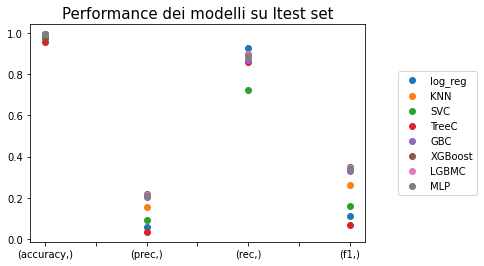

,log_reg,KNN,SVC,TreeC,GBC,XGBoost,LGBMC,MLP
accuracy,0.974755,0.991415,0.986956,0.958306,0.993891,0.994294,0.994119,0.994084
prec,0.059790,0.153982,0.090216,0.034356,0.202381,0.218362,0.213075,0.210654
rec,0.928571,0.887755,0.724490,0.857143,0.867347,0.897959,0.897959,0.887755
f1,0.112346,0.262443,0.160452,0.066064,0.328185,0.351297,0.344423,0.340509


In [ ]:
## COMPARAZIONE FINALE DEL MODELLI SUL TEST SET
performance_df=pd.DataFrame(performance, index=[['accuracy','prec','rec','f1']])
performance_df.plot(marker='o',lw=0)
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.title('Performance dei modelli su ltest set',fontsize=15)
plt.show()
performance_df

# Frodi come Anomly Detection

<a id="anomalymod"></a>

I tipi di algoritmi che useremo per provare a eseguire il rilevamento delle anomalie su questo set di dati sono i seguenti

<ul> 
<li> <b>Isolation Forest Algorithm:</b> L'algoritmo si basa sul fatto che le anomalie sono dati rari e diversi dala classe principale delle transazioni legittime. Come risultato di queste proprietà, le anomalie sonopossono essere isolate.
Questo metodo introduce l'uso dell'isolamento come mezzo più efficace ed efficiente per rilevare le anomalie rispetto alle misure di distanza e densità comunemente utilizzate. Inoltre, questo metodo è un algoritmo con una bassa complessità temporale (lineare) e un piccolo fabbisogno di memoria. La decision boundary viene creata con un numero ridotto di alberi utilizzando sottocampioni piccoli e di dimensioni fisse, indipendentemente dalle dimensioni del dataset.

Il criterio utilizzato è: isolare le osservazioni anomale è più facile perché sono necessarie solo poche condizioni per separare quei casi dalle osservazioni normali. Pertanto, un punteggio di anomalia può essere calcolato come il numero di condizioni richieste per separare una data osservazione.
Il modo in cui l'algoritmo costruisce la separazione è creare prima alberi di isolamento o alberi decisionali casuali. Quindi, si calcola un punteggio di anomalia come la lunghezza del percorso per isolare l'osservazione. I percorsi più brevi corrisonderanno alle anomalie. </li>



<li>  <b>Local Outlier Factor(LOF) Algorithm:</b>  L'algoritmo LOF è un metodo di rilevamento outlier non supervisionato che calcola la deviazione della densità locale di un dato punto dati rispetto ai suoi vicini. Considera  come campioni anomali quelli che hanno una densità sostanzialmente inferiore rispetto ai loro vicini.
Il numero di vicini considerato, (parametro n_neighbors) viene in genere scelto 1) maggiore del numero minimo di oggetti che un cluster deve contenere 2) minore del numero massimo di vicini che possono potenzialmente essere valori anomali locali. In pratica, tali informazioni generalmente non sono disponibili e prendere n_neighbors=20 sembra funzionare bene in generale.
</li>


<li>  <b>support vector machine Algorithm:</b>
I support vector machine sono in genere associati al supervised learning, ma ci sono estensioni (OneClassSVM, ad esempio) che possono essere utilizzate per identificare le anomalie come problemi non supervisionati (in cui i dati di training non sono etichettati). L'algoritmo apprende l'ipersuperficie di confine per raggruppare le normali istanze di dati utilizzando il training set, quindi, utilizzando il test set, si sintonizza per identificare le anomalie che non rientrano nella regione appresa. 
</li>
</ul>

## Metodo:
<ul> 
<li> Determina il livello di outlier nel training set (facilita la convergenza)
</li>
<li> Inizializza i modelli
</li>
<li> Hyperparameter tuning (no, per mancanza di tempo. Simile alla classificazione.)
</li>
<li> Valutazione delle performance sul test set
</li>
</ul> 


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


In [ ]:
# Calcolo (o stima) della frazione di frodi nel dataset
outlier_fraction = (y==1).sum()/(y==0).sum()

In [ ]:
detectors = {
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction, novelty = True), 
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction, verbose=0)
}

<h2>Training e valutazione delle performance <h2/>
<a id="anomalyperf"></a>

In [ ]:
for i, (detector_name,detector) in enumerate(detectors.items()):
    #Fit the data and tag outliers
    if detector_name == "Local Outlier Factor":
        detector.fit(X)
        y_pred = detector.predict(X)
        y_pred_test = detector.predict(original_Xtest)
        #scores_prediction = detector.negative_outlier_factor_
    elif detector_name == "Isolation Forest":  
        detector.fit(X)  
        #scores_prediction = detector.decision_function(X)
        y_pred = detector.predict(X)
        y_pred_test = detector.predict(original_Xtest)
    elif detector_name == "Support Vector Machine":  
        detector.fit(X)  
        y_pred = detector.predict(X)
        y_pred_test = detector.predict(original_Xtest)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    y_pred_test[y_pred_test == 1] = 0
    y_pred_test[y_pred_test == -1] = 1

    n_errors = (y_pred != y).sum()
    n_errors_test = (y_pred_test != original_ytest).sum()

    # Run Classification Metrics
    print(f"\nName: {detector_name}")
    print(f"Training set")
    print(f"Errors: {n_errors}")
    accuracy = accuracy_score(y, y_pred)
    prec,rec,f1,_=precision_recall_fscore_support(y, y_pred, average='binary')
    print(f"Accuracy: {round(accuracy*100,2)}")
    print(f"Precision: {round(prec*100,2)}")
    print(f"Recall: {round(rec*100,2)}")
    print(f"F1: {round(f1*100,2)}\n")

    print(f"Test set")
    print(f"Errors: {n_errors_test}")
    accuracy = accuracy_score(original_ytest, y_pred_test)
    prec,rec,f1,_=precision_recall_fscore_support(original_ytest, y_pred_test, average='binary')
    print(f"Accuracy: {round(accuracy*100,2)}")
    print(f"Precision: {round(prec*100,2)}")
    print(f"Recall: {round(rec*100,2)}")
    print(f"F1: {round(f1*100,2)}\n")
    print('-----'*50)


Name: Support Vector Machine
Training set
Errors: 11222
Accuracy: 95.07
Precision: 3.0
Recall: 87.56
F1: 5.79

Test set
Errors: 3152
Accuracy: 94.47
Precision: 2.75
Recall: 90.82
F1: 5.35

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"



Name: Local Outlier Factor
Training set
Errors: 736
Accuracy: 99.68
Precision: 0.0
Recall: 0.0
F1: 0.0

Test set
Errors: 207
Accuracy: 99.64
Precision: 1.77
Recall: 2.04
F1: 1.9

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"



Name: Isolation Forest
Training set
Errors: 527
Accuracy: 99.77
Precision: 33.16
Recall: 33.25
F1: 33.21

Test set
Errors: 124
Accuracy: 99.78
Precision: 35.56
Recall: 32.65
F1: 34.04

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# FAVAR: 
<a id="FAVAR"></a>
## Augmenting VARs with factors

Un modo per eseguire previsioni con molte serie temporali è eseguire la riduzione delle dimensioni (come PCA) per produrre dati riassuntivi, fare previsioni su quelli e, successivamente, mappare le previsioni sui singoli dati. Nel caso della PCA, questo produce un **Dynamic Factor Model**. 

Un altro metodo da applicare se sei principalmente interessato a prevedere una (o un piccolo numero di) serie ma hai molte serie possibili che potrebbero aiutare nelle previsioni è 
1) calcolare prima un riepilogo dell'insieme grande, 
2) Unire il riepilogo alla serie cui si è ineressati e applicare un metodo di previsione multivariato alla serie ridotta (come un'autoregressione vettoriale (VAR))

Se i riepiloghi sono i componenti principali di un set di dati, che può contenere o meno le serie di interesse, questo metodo produce la **Factor Augmented Vector Autoregression**, or **FAVAR**. Questo procedimento non è ridondante perché la riduzione dimensionale conserva le informazioni condivise ma, in generale, la serie originale non è perfettamente collineare con i fattori creati.

Data una collezione X di serie temporali e una serie di interesse y, il modello FAVAR a $q$ fattori e $p$ lags, ha la forma
$$X_t=\Lambda F_t + e_t$$
$$z_t:=(y_t,F_{1,t},\ldots,F_{qt})$$
$$z_{t}=A_0+\sum_{j=1}^{p} A_{j}z_{t-j}+u_{t}$$

Puoi adattarlo eseguendo prima PCA per ottenere i fattori $F_t$, quindi aggiungendoli a un VAR standard. Oppure puoi assumere una distribuzione per i termini $e_t$, $u_t$ e utilizzare metodi di verosimiglianza o bayesiani. Proveremo il primo, che è molto semplice.

Nel nostro caso la variabile di interesse è il **prezzo del rame**. 
Il modello permette anche di imporre restrizioni ai fattori. Alcuni indicatori economici si muovono in modo sincrono con il prezzo del rame, altri anticipano o ritardano il movimento del prezzo del rame. Per implementare questo schema di identificazione è utile definire due categorie di variabili, “slow-moving” e “fast-moving”. Una variabile "lenta" è quella che è in gran parte predeterminata a partire dal periodo corrente, mentre una variabile "rapida" - si pensi al prezzo di un asset - è altamente sensibile alle notizie economiche o agli shock contemporanei.


Fare riferimento a FactorAugmentedVAR.py per maggiori dettagli sull'esecuzione del modello. 
Sorgente del codice: https://github.com/HoagieT/Factor-Augmented-Vector-Autoregression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/BPER
# List files to make sure we're in the expected directory.
# Your output will look different, showing your own Drive files here.
!ls

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/BPER
BPER_hands_on_unbalanced.ipynb	Esercitazione_python.ipynb
copper_price_forecast.ipynb	FactorAugmentedVAR.py
creditcard.csv			Functions.py
creditcardfraud			gdp-forecasting-with-favars.ipynb
economic_data.xlsx		__pycache__


In [ ]:
from FactorAugmentedVAR import *
from Functions import *
from datetime import *
import warnings
warnings.filterwarnings('ignore')

<h4> 2. Data Description </h4>

I quattro maggiori consumatori di metallo sono Stati Uniti, Cina, Germania e Giappone. Pertanto, includiamo nel set di dati alcuni dei più importanti indicatori economici di queste quattro nazioni.

I dati di gennaio e febbraio degli indicatori cinesi sono stati rimossi a causa dell'anomalia della Festa di Primavera. Questa è una pratica comune quando si studiano gli indicatori economici cinesi perché il Festival di Primavera può cadere in gennaio o in febbraio. Per semplicità di esecuzione, in questo esercizio, i dati rimossi e mancanti vengono sostituiti con l'**interpolazione**. In alternativa, potete anche utilizzare un filtro Kalman per stimare i dati mancanti. Nella cartella potete trovare un file KalmanFilter.py da usare a questo scopo.

Tutti i dati sono stati trasformati per rendere stazionarie le serie temporali.

Text(0.5, 0, 'years')

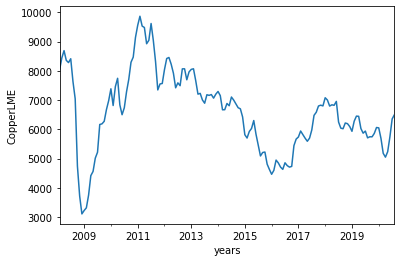

In [ ]:
"Data Import"
file_name='economic_data.xlsx'
sheet_name='transformed_vintage'
Temp = pd.read_excel(file_name, sheet_name)
vintage_transformed = Temp.iloc[:,1:]
vintage_transformed.index = Temp.iloc[:,0]

"Data Interpolation"
vintage_intrpl = DataInterpolation(vintage_transformed[1:], 0, len(vintage_transformed.index), 'slinear').dropna(axis=0,how='any')

vintage_intrpl['CopperLME'].plot()
plt.ylabel('CopperLME')
plt.xlabel('years')


# Stazionarietà

Utilizziamo l'ADFuller test

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    #print(f' Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'"{name}"', "\n   ", '-'*47)
    #print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    #print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
    #    print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        #print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
        return True
    else:
        #print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
        return False

In [ ]:
stat_list=[]
for name, column in vintage_intrpl.iteritems():
    stat_list.append(adfuller_test(column, name=column.name))
    print('\n')

"CopperLME" 
    -----------------------------------------------
 => Series is Stationary.


"CN-CNYExchangeRate.D1" 
    -----------------------------------------------
 => Series is Stationary.


"US-TB10Y.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.US-TB1Y.D1" 
    -----------------------------------------------
 => Series is Stationary.


"SP500.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.US-M1.D1" 
    -----------------------------------------------
 => Series is Non-Stationary.


"Log.US-M2.D1" 
    -----------------------------------------------
 => Series is Non-Stationary.


"Log.CN-M1.D1" 
    -----------------------------------------------
 => Series is Non-Stationary.


"Log.CN-M2.D1" 
    -----------------------------------------------
 => Series is Non-Stationary.


"DJI.D1" 
    -----------------------------------------------
 => Series is Stationary.


"DollarIndex.D1" 
    -----


Tutte le serie che non sono stazionarie devono essere rese tali e sostituite all'interno del dataset. A tal fine consideriamo le differenze prime delle serie non stazionarie.

In [ ]:
## Compute difference and 
stat_df=(vintage_intrpl.diff()).fillna(0)

In [ ]:
for (i,el) in enumerate(vintage_intrpl.columns):
  if stat_list[i]:
    stat_df[el]=vintage_intrpl[el]

In [ ]:
for name, column in stat_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

"CopperLME" 
    -----------------------------------------------
 => Series is Stationary.


"CN-CNYExchangeRate.D1" 
    -----------------------------------------------
 => Series is Stationary.


"US-TB10Y.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.US-TB1Y.D1" 
    -----------------------------------------------
 => Series is Stationary.


"SP500.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.US-M1.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.US-M2.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.CN-M1.D1" 
    -----------------------------------------------
 => Series is Stationary.


"Log.CN-M2.D1" 
    -----------------------------------------------
 => Series is Stationary.


"DJI.D1" 
    -----------------------------------------------
 => Series is Stationary.


"DollarIndex.D1" 
    ---------------------

<h2> Calcolo dei fattori comuni </h2>

I fattori comuni per tutte le variabili, ovvero il prezzo del rame e le variabili fast/slow-moving sono indicati con C. I fattori comuni calcolati dalle variabili slow-moving sono indicati con F. La variabile di interesse, ovvero il prezzo del rame, è indicata con Y.

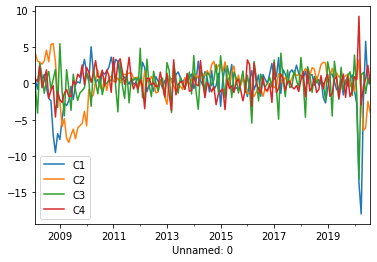

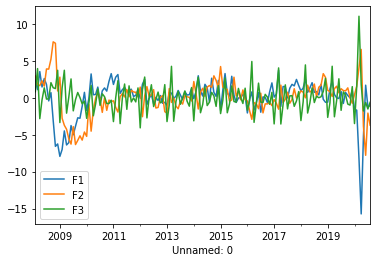

In [ ]:
factor = Factor(Y=pd.DataFrame(stat_df.iloc[:,0]), X_slow=stat_df.iloc[:,14:], n_factors=3, X_fast=stat_df.iloc[:,1:14])

factor.C.plot()
factor.F.plot()

<h2> Step 2: Calcolo di SVAR su F e Y e predizione </h2>

Applicare la classica structural vector autoregression su Y e F.

In [ ]:
favar = FAVAR(Factor=factor.F, Y=pd.DataFrame(stat_df.iloc[:,0]), lag=3)
#favar.VAR.summary()

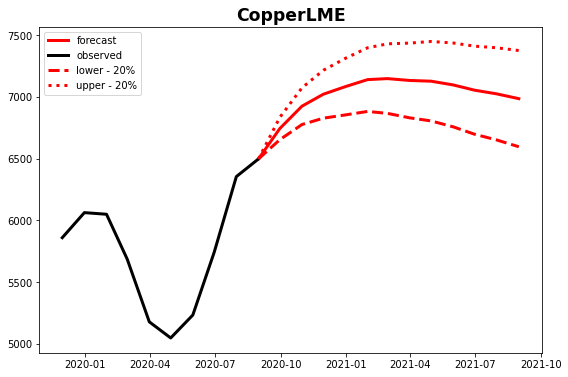

In [ ]:
mean, low, up = favar.predict(Factor=factor.F[-5:], Y=pd.DataFrame(stat_df.iloc[-5:,0]), step=20)

favar.predict_plot(Factor=factor.F[-5:], Y=pd.DataFrame(stat_df.iloc[-10:,0]), step=12, freq='M', alpha=0.8, figure_size=[9,6],line_width=3.0,font_size='xx-large', actural='None')